# The Watershed Algorithm

### What is a watershed?
_In Geography, a watershed is a land area that channels rainfall amd snowmelt to creeks, streams and rivers. Eventually to outflow points such as reservoirs, bays or the ocean itself. They can be segmented as topiograpical maps with boundaries._

### The Algorithm Description
_Metaphorically, the watershed algorithm transformation treats an image it works upon like a topigraphical map, the brightness of each point representing height, finding the lines that run along the tops of ridges etc._

### Applying the same thinking to Images.
Any grayscale image can be viewed as a topographical surface where high intensity denotes peaks and hills whilst low inensity as akin to valleys as found in the topographical references above. 

What this means is: 
- The watershed algorith can subsequently fill isolated valleys (local minima) with different coloured water labels. 
- As the image intesity rises, depending on the peaks (gradients) nearby, the contours from different segments may start to merge. To avoid merging the algorithm creates synthetic barriers at segment edge boundaries to prevent merge. 

What is it useful for?
- segmenting images into background and foreground in situations that are difficult for other/alternative algorithms.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-dark-palette')

In [2]:
# Convenience functions 

def show(img, color=True):
    fig = plt.figure(figsize=(16,10))    
    ax = fig.add_subplot(111)
    if color:
        ax.imshow(img)
    else:
        ax.imshow(img, cmap='gray')

def show_two(img1, img2, color=True):
    fig = plt.figure(figsize=(16,12))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    if color:
        ax1.imshow(img1)
        ax2.imshow(img2)
    else:
        ax1.imshow(img1, cmap='gray')
        ax2.imshow(img2, cmap='gray')

# Read in the sample data

In [3]:
orig_coins = cv2.imread('DATA/pennies.jpg')
sep_coins = cv2.imread('DATA/pennies.jpg')

# Demonstrate results without the watershed. 

Using already covered topics we are going to see how difficult it is to achieve even a mediocre result in the circumstances of this test. We need to utilise blurring, color conversions, binary thresholding and contour drawing. 

In [4]:
# median blur 
sep_blur = cv2.medianBlur(sep_coins, 25)
# grayscale
gray_sep = cv2.cvtColor(sep_blur, cv2.COLOR_BGR2GRAY)
# binary threshold
ret, thresh = cv2.threshold(gray_sep, 160, 255, cv2.THRESH_BINARY_INV)
# find contours 
img, contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(sep_coins, contours, i, (255, 0, 0), 10)

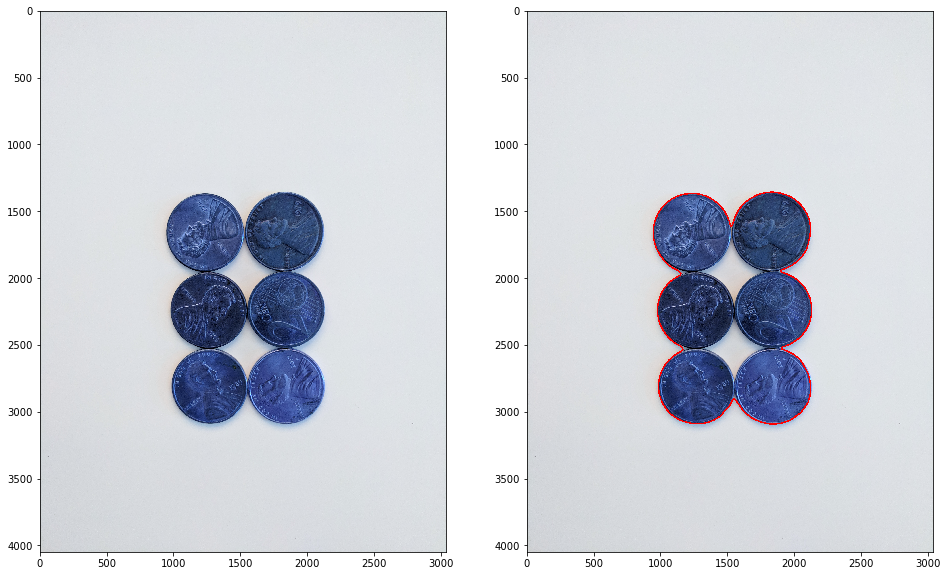

In [5]:
show_two(orig_coins, sep_coins)

# Using the Watershed Algorithm

### step one: Load the data

In [6]:
orig_img = cv2.imread('DATA/pennies.jpg')
img = cv2.imread('DATA/pennies.jpg')

### Step Two : Apply a median blur and transform to grayscale

In [7]:
# blur
img = cv2.medianBlur(img, 35)
# convert to gray 
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

### Step Three : Create a threshold, create a kernel and open the image to get the background

In [8]:
# we will utilise Utsu's method which is another type of
# thresholding which works very well with the watershed 
# algorithm. 
ret, thresh = cv2.threshold(img, 0,255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal kernel settings 
kernel = np.ones((3,3), np.uint8)

# open the image to get the background. 
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

sure_bg = cv2.dilate(opening, kernel, iterations=3)

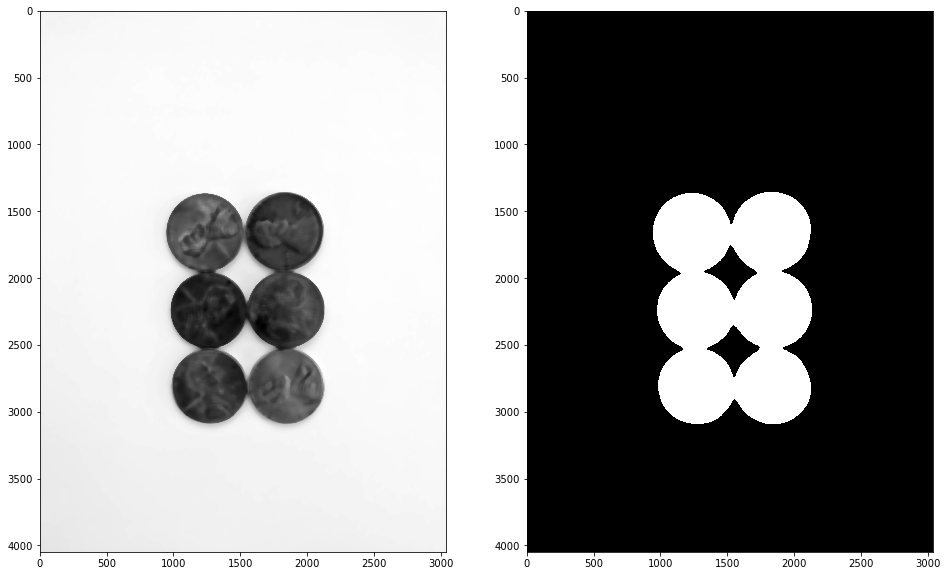

In [9]:
# demonstrate the background identified from the original.
show_two(img, sure_bg, False)

### Step Four : Distance transformations 

In [10]:
# paramas: source, distancing type function, mask size
dist_transform = cv2.distanceTransform(sure_bg, cv2.DIST_L2, 5)

In [11]:
# calculate the sure foreground 
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

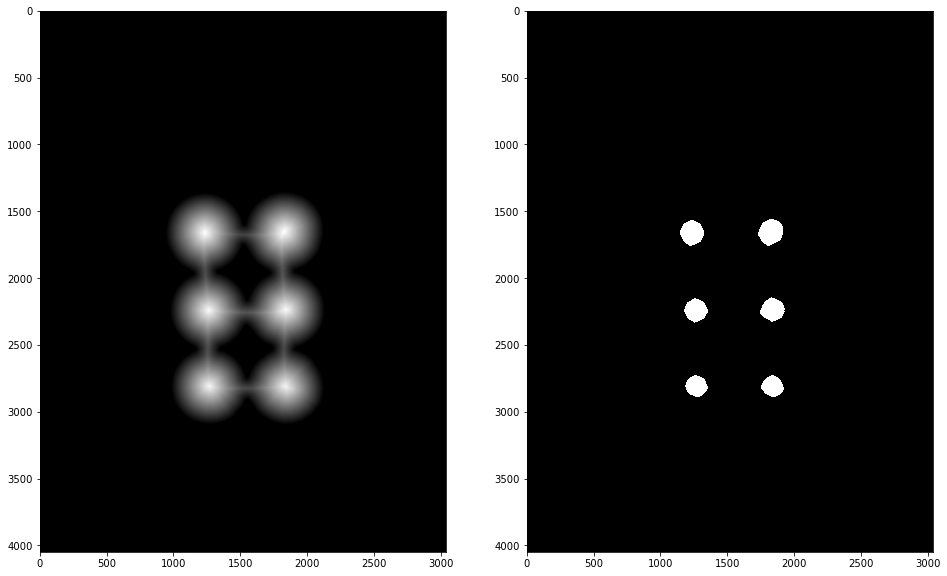

In [12]:
show_two(dist_transform,sure_fg, False)

# MILESTEONE : Before watershed

We're at a milestone, as we now have a sure background and a sure foreground. 

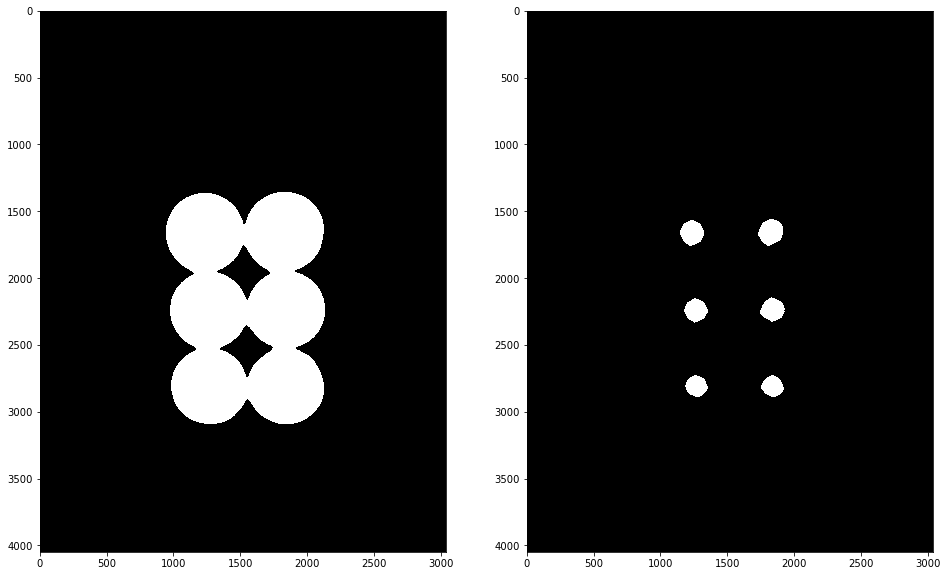

In [13]:
show_two(sure_bg, sure_fg, False)

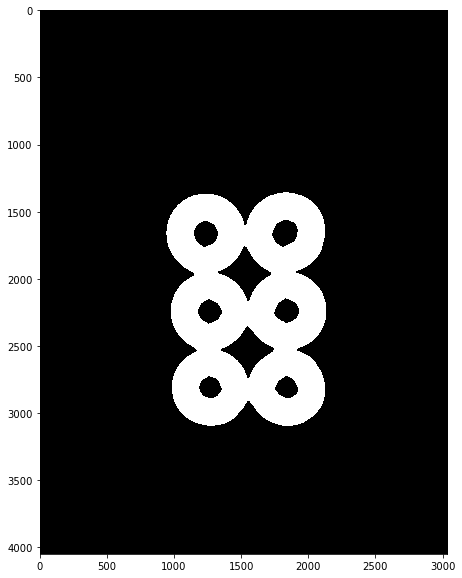

In [14]:
sure_fg = np.uint8(sure_fg)
unknown_region = cv2.subtract(sure_bg, sure_fg)
show(unknown_region, False)

We need to take the 6 markers and label as seeds that the watershed algorithm will use.

### Step Five : The Markers 

In [15]:
# crete the markers 
ret, markers = cv2.connectedComponents(sure_fg)

# If we display the markers at this stage it is a collection of zeroes. 
# We need to add one to the markers 
markers = markers + 1

In [16]:
# now we mark the region of unknown with zero
markers[unknown_region==255] = 0

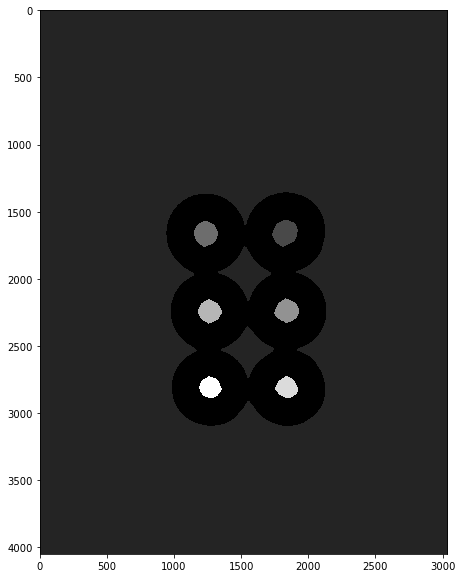

In [17]:
show(markers, False)

We now have the seeds required in order to apply the watershed algorithm 

### Step Six : Apply the watershed

In [18]:
markers = cv2.watershed(orig_img, markers)

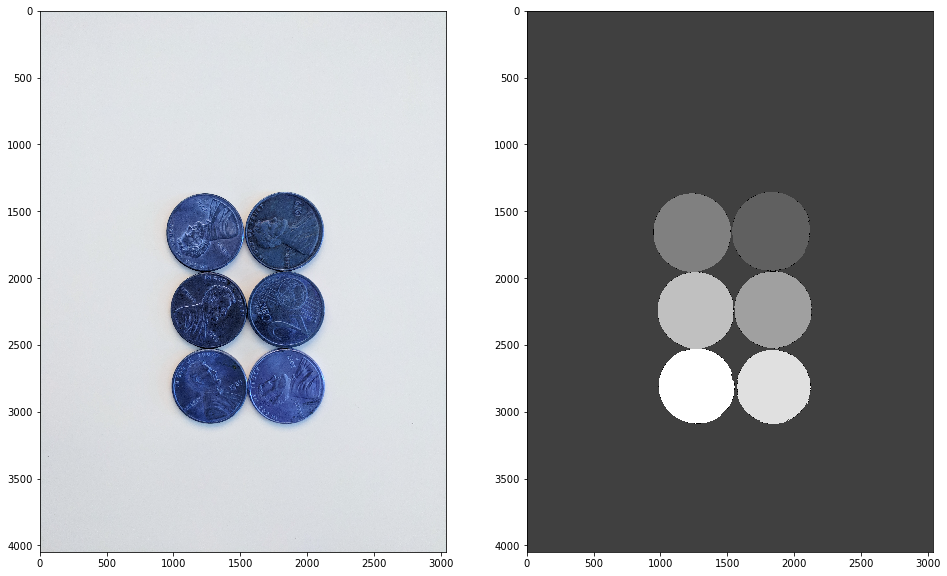

In [19]:
show_two(orig_img, markers, False)

### Step Seven : Grab the contours 

In [20]:
img, contours, hierarchy = cv2.findContours(markers, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

In [21]:
for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(sep_coins, contours, i, (255, 0, 0), 10)

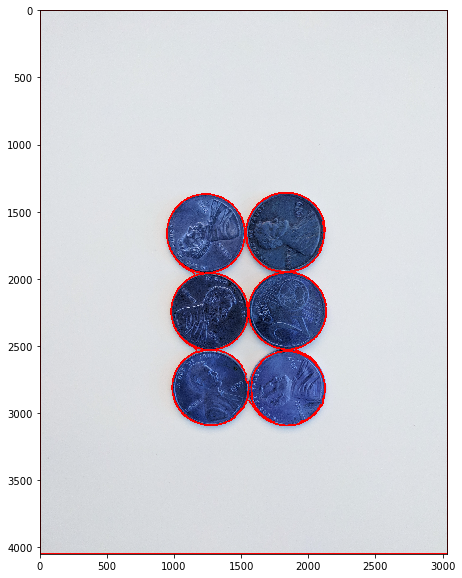

In [22]:
show(sep_coins,False)